# Case Study: Ocean Health Indicators in Folger Passage

For the best learning experience please work through the Plotting Tutorial notebook before starting this one.

In this coding notebook we will combine real-world data science with ocean monitoring to explore the health of the local ecosystem. In this case study, we’ll focus on Folger Passage, located in the Bamfield region on the west coast of Vancouver Island, within Huu-ay-aht ḥahuułi (territory). See the map below to situate yourself in this region. This area is home to two key Ocean Networks Canada (ONC) observatories: Folger Deep (location code: FGPD) and Folger Pinnacle (location code: FGPPN). 

<img src="(3) Folger Passage 2021 files/folger_passage_overview.png" width="" align="" />

See the figures below for more information on the two major stations in Folgers Passage, Folger Deep and Folger Pinnacle. Note one of the graphics displays the sensors available at each station while the other gives you a depth perspective using a profile view. 

<img src="(3) Folger Passage 2021 files/folger_passage_sensors.png" width="" align="" />

Folger Passage overview, including the sensors available at Folger Deep and Folger Pinnacle.

<img src="(3) Folger Passage 2021 files/folger_passage_bathymetry.jpg" width="" align="" />

A profile view of the Folger Deep and Folger Pinnacle stations, giving a perspective of the difference in depth between the two stations.

Using ONC data, you’ll learn how to programmatically access and work with oceanographic data collected from these underwater stations. We’ll walk through how to retrieve and visualize datasets, with a focus on a low oxygen event that occurred in August 2021. This workbook was inspired by the work of Franco et al., 2023 titled Drivers and Potential Consequences of Observed Extreme Hypoxia Along the Canadian Pacific Continental Shelf (https://doi.org/10.1029/2022GL101857). This is a key local example of how environmental events can be detected and interpreted using real-time ocean data.

By the end of this workbook, you’ll have hands-on experience in:

- Accessing and filtering ocean sensor data using Python

- Exploring physical and biogeochemical trends

- Interpreting ocean health indicators in a real-world context

Let’s dive in!

For definitions of the technical terminology used throughout this notebook please see the notebook titled Glossary. You will also find all the information on the locations, devices, and properties we use throughout this notebook.

Key words: API, token, library, variable, input/parameter, query, function, DataFrame

### 1. Set Up Programming Environment

Like in the Plotting Tutorial (section 1), the first step in setting up your programming environments is to install and import your libraries.

We install the libraries listed in requirements.txt in the code block below.

In [1]:
!pip install -r ./requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 118.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.1/222.1 kB 48.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.1/132.1 kB 16.4 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.6.3
    Uninstalling matplotlib-3.6.3:
      Successfully uninstalled matplotlib-3.6.3

[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


The next step is to import the libraries we plan to use in this notebook, which we do in the following block.

In [2]:
import onc                 # Import the ONC client library
import pandas              # Import the pandas library for data manipulation

## 2. Plotting One Year at Folger Passage

We will now plot year of data at two locations in Folger Passage— Folger Deep and Folger Pinnacle.

### 2.0.1 Introduction to Helper Files

Unlike the plotting tutorial, we will not call the ONC client library directly. Because retrieving many properties from each location would involve numerous getScalardata calls, substantial response parsing, and additional work to consolidate everything into a single DataFrame*, we instead rely on a helper module, ONC_client.py, to handle these operations.

ONC_client.py contains several helper functions. Recall that a  function is a small, reusable piece of code that does a specific task to make a bigger program easier to read and use. The helper functions from this file do the following:

- __init__: Uses our token to connect to the ONC API (Plotting Tutorial section 3.1)

- fetch_property_result: Makes a getScalardata request for a single property (Plotting Tutorial section 3.2).

- result_to_dataframe: Extracts relevant information from a getScalardata response and places it into a DataFrame (Plotting Tutorial section 5).

- get_multi_property_dataframe: For each property in a given list of property codes this function calls methods fetch_property_result and result_to_dataframe above, and thus produces a DataFrame for each property. It then combines each property's DataFrame into a single DataFrame.

The code below imports ONC_client.py, the file where we have written our functions, allowing us to use them in this notebook, similar to a library.

In [3]:
import ONC_client        # File with functions for managing API connection and requests

* Recall from the Plotting Tutorial that a DataFrame is a table made with Python’s pandas library. It looks like a spreadsheet, with rows and columns for organizing data (like temperature or oxygen) so it’s easy to analyze and plot.

### 2.1 Connect to the API

Before the ONC_client.py file can make our API requests, it first must connect to the API using a personal token. 

Your token lets the API know who you are and gives you permission to access the data. You can find your token by logging into https://data.oceannetworks.ca/, viewing your profile, and clicking the Web Services API tab.

<img src="(3) Folger Passage 2021 files/onc_token.png" width="" align="" />

> Enter your token below.

In [ ]:
onc_client = ONC_client.ONCSensorClient(token="YOUR TOKEN HERE") # INTERACTIVE: Enter your token (in quotes).

### 2.2 Define Parameters for Each Location

Next, even though we are not directly using the Client library, we need to supply ONC_client.py with all of the information required to construct a valid API query.

In the code block below, we define this information.

Like in the Plotting Tutorial notebook (section 2.1) we define our parameters according to what we are interested in:

- When: Our time series is the year or 2021.

- Where: Our location codes correspond to Folger Deep and Folger Pinnacle.

- What: Our properties of interest differ by location. At Folger Deep, we are interested in oxygen, salinity, sea water temperature, density and sigma-t. At Folger Pinnacle, we are interested in oxygen, chlorophyll a, salinity, turbidity, sea water temperature, density and sigma-t.  

- How often: We also set a subsampling period for 1800 seconds because our time series spans an entire year, and the API can return a maximum of 100,000 lines per response (i.e. about 1.5 days of unsampled data).

In [5]:
# Time frame - the year of 2021
# Type: string
start_21 = "2021-01-01T00:00:00.000Z"  # Start date
start_22 = "2022-01-01T00:00:00.000Z"  # End date

# Location Codes for Deep and Pinnacle
# See documentation - https://wiki.oceannetworks.ca/x/gYLyAg
# Type: string
deep_locationCode = "FGPD" 
pinnacle_locationCode = "FGPPN"

# Properties available at Folger Deep and Folger Pinnacle
# See documentation - https://wiki.oceannetworks.ca/x/2w7nAg
# Type: list of strings
deep_properties = ["oxygen", "salinity", "seawatertemperature", "density", "sigmat"]
pinnacle_properties = ["oxygen", "salinity", "seawatertemperature", "density", "sigmat", "chlorophyll", "turbidityntu"]

# Resample (necessary for time series greater than 1 day)
# Type: integer
resample = 1800 # Sets subsampling period for every 1800 seconds

Notice how we define our parameters in the form label = value. 

This format follows the basic structure of a variable, where the label (or variable name) identifies the data, and the value is the information stored. Variables are fundamental building blocks in programming — they allow us to store, reuse, and update information throughout our code.

### 2.3 Create DataFrame of Properties for Each Location

Now we can give ONC_client.py the information we defined in section 2.2. It will then use this information to create the parameters to request data from the API for each property, extract the relevant data from each response, then store it all in a single DataFrame.

Below, the program creates the DataFrame for Folger Deep. In the output box below the code we can see the individual API calls ONC_client.py makes, and when the final DataFrame is complete.

In [6]:
# Create the DataFrame for Folger Deep
# Refer to ONC_client.py file to understand get_multi_property_dataframe function
deep_yr_21_indicators = onc_client.get_multi_property_dataframe(
    start=start_21,                         # Start date; Format: "YYYY-MM-DDTHH:MM:SS.sssZ" 
    end=start_22,                           # End date; Format: "YYYY-MM-DDTHH:MM:SS.sssZ"                     
    location_code=deep_locationCode,        # Location code   
    property_codes=deep_properties,         # List of parameters to request.     
    resample=resample,                      # Time interval (in seconds) to average data
    updates=True)                           # Set to True to print API request status and progress

API Request: getScalardata{'locationCode': 'FGPD.O2', 'deviceCategoryCode': 'OXYSENSOR', 'propertyCode': 'oxygen', 'dateFrom': '2021-01-01T00:00:00.000Z', 'dateTo': '2022-01-01T00:00:00.000Z', 'metadata': 'minimum', 'qualityControl': 'clean', 'resamplePeriod': 1800, 'resampleType': 'avg', 'sensorCategoryCodes': 'oxygen_corrected'}
API Request: getScalardata{'locationCode': 'FGPD', 'deviceCategoryCode': 'CTD', 'propertyCode': 'salinity', 'dateFrom': '2021-01-01T00:00:00.000Z', 'dateTo': '2022-01-01T00:00:00.000Z', 'metadata': 'minimum', 'qualityControl': 'clean', 'resamplePeriod': 1800, 'resampleType': 'avg'}
API Request: getScalardata{'locationCode': 'FGPD', 'deviceCategoryCode': 'CTD', 'propertyCode': 'seawatertemperature', 'dateFrom': '2021-01-01T00:00:00.000Z', 'dateTo': '2022-01-01T00:00:00.000Z', 'metadata': 'minimum', 'qualityControl': 'clean', 'resamplePeriod': 1800, 'resampleType': 'avg'}
API Request: getScalardata{'locationCode': 'FGPD', 'deviceCategoryCode': 'CTD', 'propertyC

The code below displays a preview of the first 5 rows of the DataFrame. Notice how the name of the variable ('deep_yr_21_indicators') is specific to the data it holds.

In [7]:
deep_yr_21_indicators # Preview the DataFrame for Folger Deep

,Oxygen (ml/l),Salinity (psu),Temperature (°C),Density (kg/m3),Sigma-t (kg/m3)
Time,,,,,
2021-01-01 00:15:00+00:00,NaN,31.837662,9.368090,1025.020570,24.585439
2021-01-01 00:45:00+00:00,NaN,31.837139,9.362289,1025.019496,24.585946
2021-01-01 01:15:00+00:00,NaN,31.831736,9.362302,1025.013739,24.581721
2021-01-01 01:45:00+00:00,NaN,31.826527,9.362097,1025.008372,24.577683
2021-01-01 02:15:00+00:00,NaN,31.814458,9.364466,1024.997534,24.567878
...,...,...,...,...,...
2021-12-31 21:45:00+00:00,NaN,31.523383,10.118536,1024.651376,24.219021
2021-12-31 22:15:00+00:00,NaN,31.522272,10.124838,1024.647840,24.217115
2021-12-31 22:45:00+00:00,NaN,31.522845,10.131310,1024.645672,24.216493


The red bars above represent periods where ONC is missing data.

Now that we have created and previewed the DataFrame for Folger Deep, lets do the same for Folger Pinnacle.

> Create a DataFrame called 'pin_yr_21_indicators' for all properties available at Folger Pinnacle in the year of 2021. You should use the variables defined in section 2.2 and follow the same structure we used for Folger Deep. (5 minutes)

In [ ]:
# Create the DataFrame for Folger Pinnacle
pin_yr_21_indicators = onc_client.get_multi_property_dataframe(
    start="START DATE (ISO 8601 UTC)",                     # Start date; Format: "YYYY-MM-DDTHH:MM:SS.sssZ"
    end="END DATE (ISO 8601 UTC)",                         # End date; Format: "YYYY-MM-DDTHH:MM:SS.sssZ"
    location_code='LOCATION CODE',                         # Location code
    property_codes='LIST OF PROPERTY CODES',               # List of parameters to request.
    resample='SUBSAMPLING PERIOD',                         # Time interval (in seconds) to average data
    updates=True                                           # Set to True to print API request status and progress
)

In [9]:
pin_yr_21_indicators # Preview the DataFrame for Folger Pinnacle

,Oxygen (ml/l),Salinity (psu),Temperature (°C),Density (kg/m3),Sigma-t (kg/m3),Chlorophyll (µg/l),Turbidity (NTU)
Time,,,,,,,
2021-01-01 00:15:00+00:00,6.418278,29.356030,9.125013,1022.789966,22.683785,0.173206,0.823635
2021-01-01 00:45:00+00:00,6.417333,29.282496,9.079078,1022.737772,22.633191,0.168771,0.782812
2021-01-01 01:15:00+00:00,6.372171,29.251519,9.025827,1022.719933,22.616893,0.159257,0.707104
2021-01-01 01:45:00+00:00,6.365439,29.233654,9.021572,1022.705259,22.603566,0.156167,0.690834
2021-01-01 02:15:00+00:00,6.452396,29.164227,8.973576,1022.657068,22.556397,0.155061,0.669201
...,...,...,...,...,...,...,...
2021-12-31 21:45:00+00:00,NaN,30.222132,8.280649,1023.586892,23.484530,NaN,NaN
2021-12-31 22:15:00+00:00,NaN,30.254641,8.367470,1023.598297,23.497613,NaN,NaN
2021-12-31 22:45:00+00:00,NaN,30.225979,8.230905,1023.593690,23.494489,NaN,NaN


### 2.4 Create Visualizations from the DataFrames

Now that we have two DataFrames of properties— one for Folger Deep and one for Folger Pinnacle— we can plot this data. We will be using a helper file, onc_plotting.py, which contains functions that take a DataFrame for input, and output different visualizations of our data, including plots and subplots of properties of interest.

The code below imports the files where we have written our functions, allowing us to use them in this notebook, similar to libraries.

In [10]:
import onc_plotting # File with functions for plotting data from DataFrames created from getScalarData API responses

Under the files section in the panel on the left, you will find the onc_plotting.py file which you can modify if you'd like to edit features such as the axes, property colours, labels and subplots.

### 2.4.1 Folger Deep

First, let's plot all the properties in the Folger Deep DataFrame in a single figure.

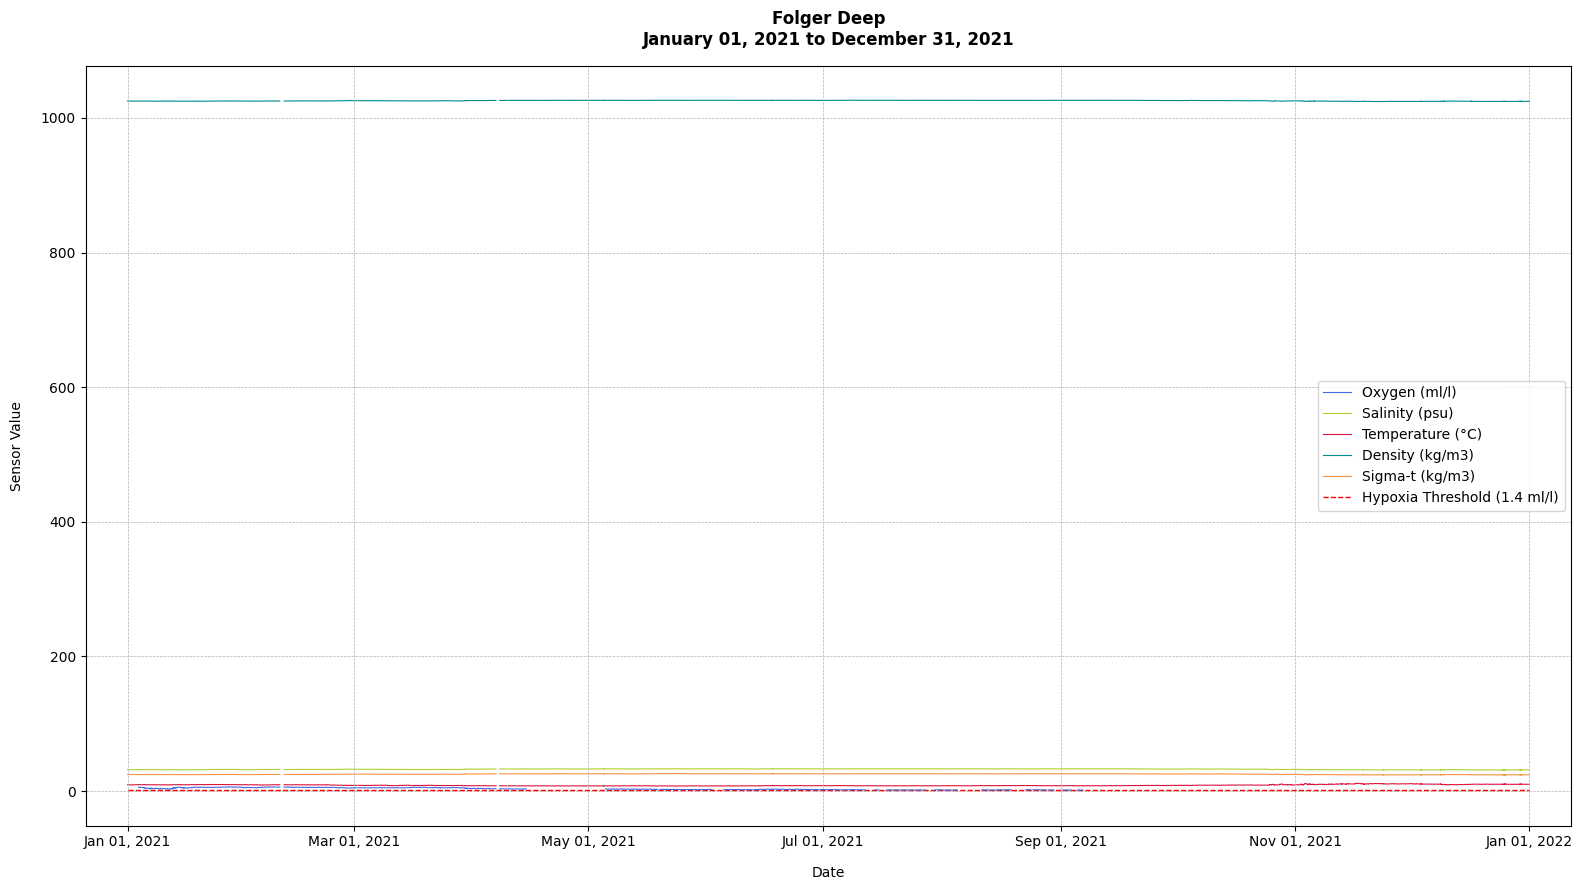

In [11]:
# Refer to onc_plotting.py file to understand plot_dataframe function
# Syntax: onc_plotting.plot.dataframe(df: pandas.DataFrame, location_code: string)
onc_plotting.plot_dataframe(df=deep_yr_21_indicators, location_code=deep_locationCode)

Notice how the absolute scale makes it difficult to view all the parameters together? 

Density is an order of magnitude higher than the others, which obscures any meaningful trends in the data. Let’s address this by exploring alternative approaches to visualizing the data.

2.4.1.1 [Option 1] Subplot Each Property

One way to look at properties with different magnitudes is to subplot each property with an individual y-axis, value, while still sharing an x-axis,  time.

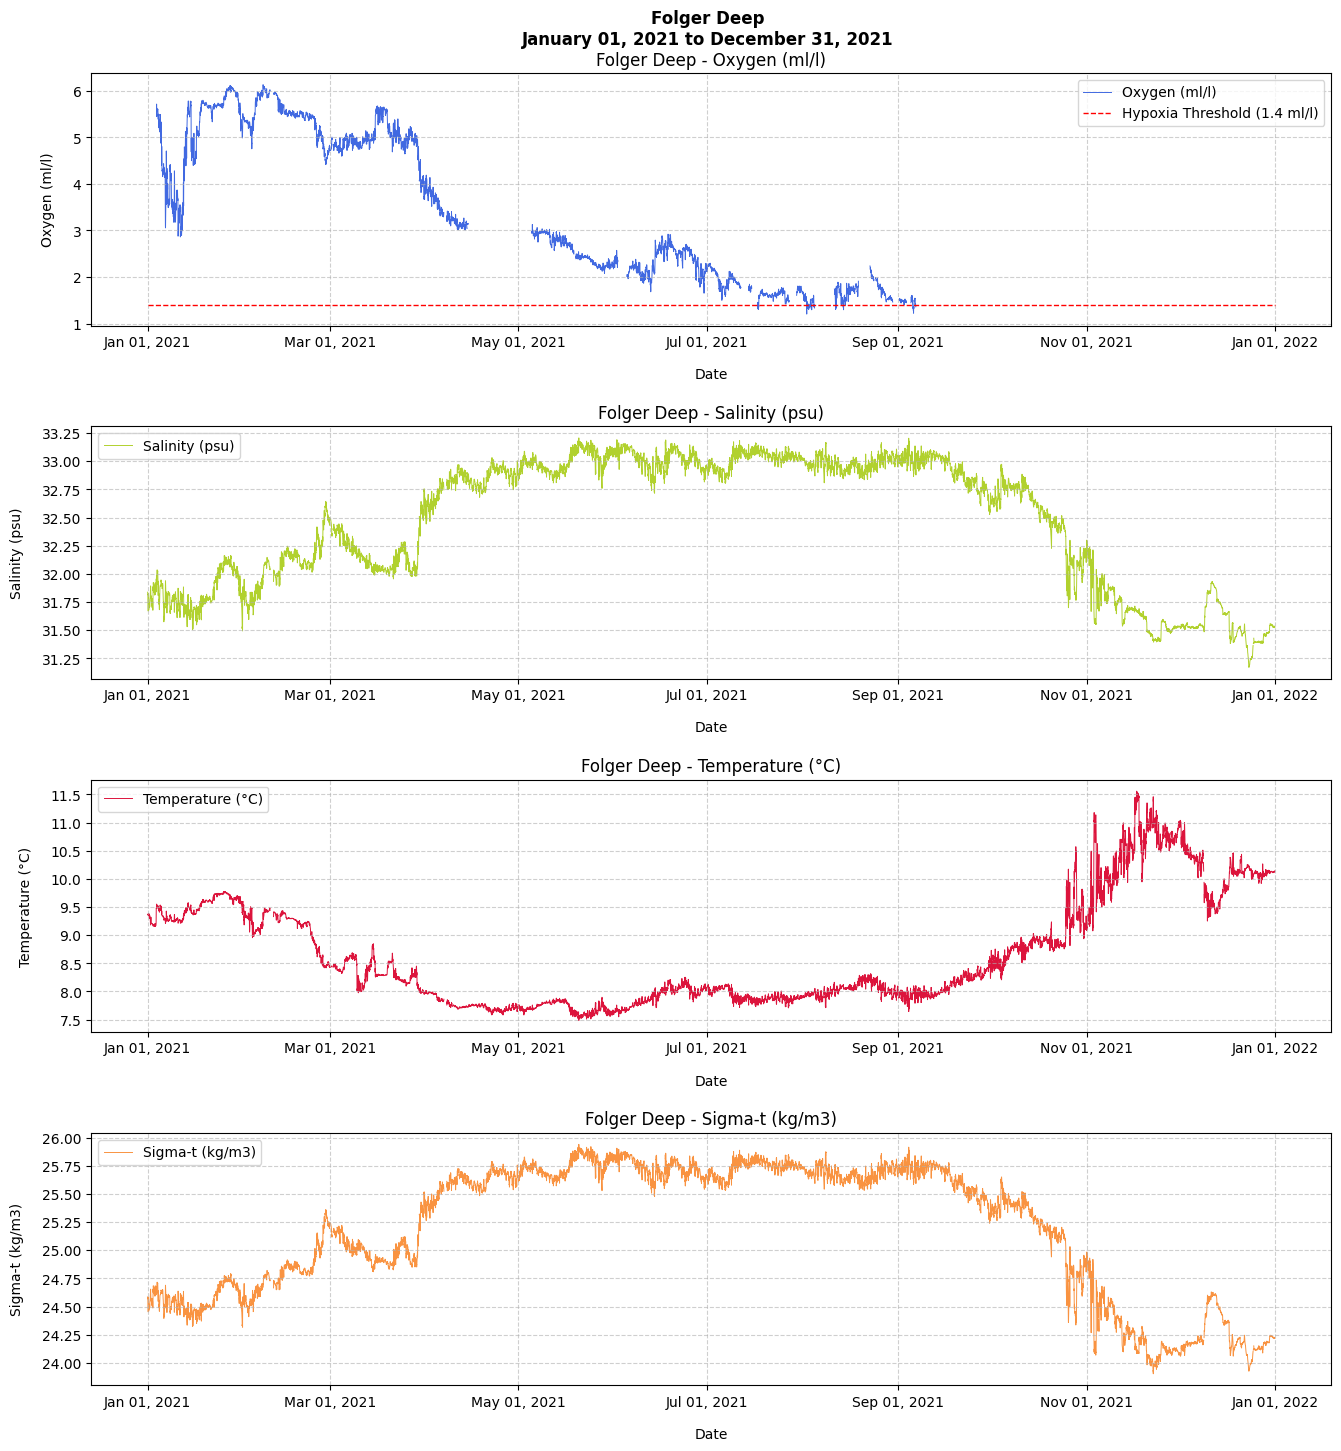

In [34]:
# Refer to onc_plotting.py file to understand subplot_all_with_time function
# Syntax: onc_plotting.subplot_all_with_time(df: pandas.DataFrame, location_code: string)
onc_plotting.subplot_all_with_time(df=deep_yr_21_indicators, location_code=deep_locationCode)

Notice in the oxygen plot above, there is a red dashed line at 1.4 ml/l. This indicates a commonly used threshold for low oxygen conditions in a marine environment. To modify this value, head over to the onc_plotting.py file and edit the value for the global variable HYPOXIA_THRESHOLD on line 14.

2.4.1.2 [Option 2] Use a Twin Y-Axis for Properties of Different Magnitudes

Another option is to create a twin y-axis for properties with the largest difference in magnitude. In this case, that is density, which now gets its own vertical axis on the right side of the plot, making it easier to compare with other parameters that have smaller scales.

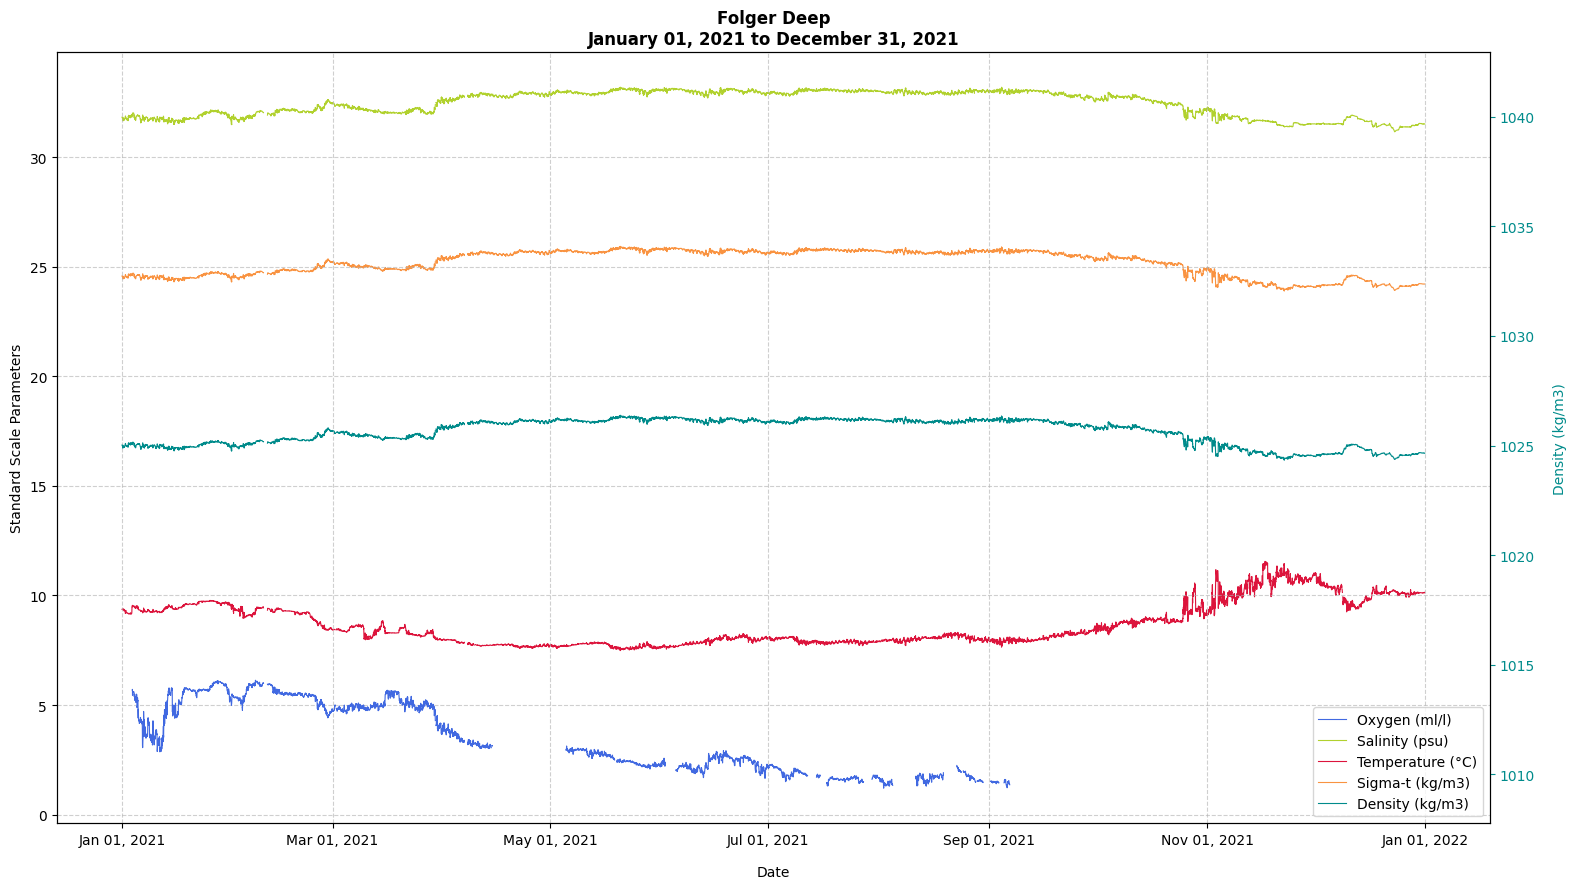

In [13]:
# Refer to onc_plotting.py file to understand plot_with_twin_y_axis_for_outlier function
# Syntax: onc_plotting.plot_with_twin_y_axis_for_outlier(df: pandas.DataFrame, location_code: string)
onc_plotting.plot_with_twin_y_axis_for_outlier(df=deep_yr_21_indicators, location_code=deep_locationCode)

2.3.1.3 [Option 3] Apply Oceanographic Knowledge

As you might have noticed, our DataFrame includes both density and sigma t. These two parameters measure the same data except density takes into account atmospheric pressure while sigma t does not. That is: sigma t = density - 1000. 

Thus, sigma t represents density but at a much lower magnitude, meaning it fits better on the plot with our other parameters. 

Below we remove the density column from our DataFrame using the pandas drop function, and plot it accordingly.

In [14]:
# Drop() method removes a column from a DataFrame— see the link above for more information
deep_yr_21_indicators.drop(labels="Density (kg/m3)", axis=1, inplace=True) 

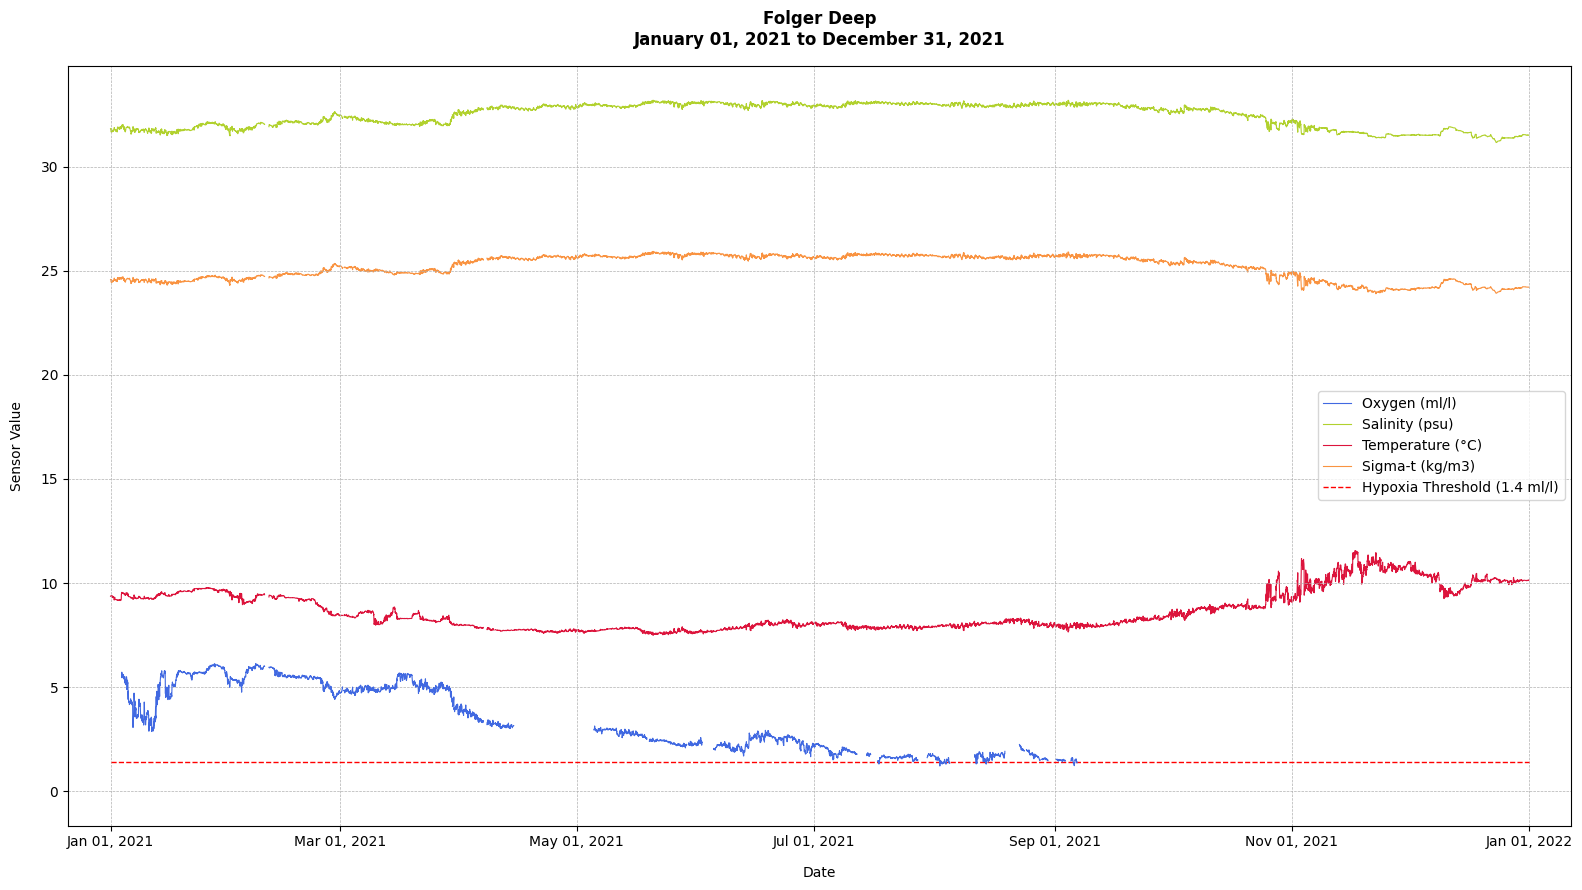

In [15]:
# Refer to onc_plotting.py file to understand plot_dataframe function
# Syntax: onc_plotting.plot_dataframe(df: pandas.DataFrame, location_code: string)
onc_plotting.plot_dataframe(df=deep_yr_21_indicators, location_code=deep_locationCode)

### 2.4.2 Folger Pinnacle

Now we'll make the same plots for Folger Pinnacle, but you have to fill in some of the parameters. Reference the variables defined in section 2.2 and the functions used to plot Folger Deep above.

> Enter the name of the Folger Pinnacle DataFrame and name of the variable storing the Folger Pinnacle location code.

In [ ]:
onc_plotting.plot_dataframe(df='DATAFRAME HERE', location_code='LOCATION CODE HERE') 

2.4.2.1 [Option 1] Subplot Each Property

> Enter the name of the plotting function below. Refer to our plots of Folger Deep above for reference.

In [ ]:
onc_plotting.'FUNCTION HERE'(df=pin_yr_21_indicators, location_code=pinnacle_locationCode) # INTERACTIVE: Enter your plotting function.

Looking at the above graphs, consider the following questions:

- Why do you think the chlorophyll started showing up on the sensor in April?

- After chlorophyll readings became very active in May - June, what happened to oxygen?

- Would you expect oxygen to increase or decrease when there is a lot of chlorophyll? Why? 

- Why do you think the temperature was generally warmer in October - November than it was in May - July?

2.4.2.2 [Option 2] Use a Twin Y-Axis for Properties of Different Magnitudes

> Enter the name of the plotting function below. Refer to our plots of Folger Deep above for reference.

In [ ]:
onc_plotting.'FUNCTION HERE'(df=pin_yr_21_indicators, location_code=pinnacle_locationCode) # INTERACTIVE: Enter your plotting function.

2.3.2.3 [Option 3] Apply Oceanographic Knowledge

In [19]:
pin_yr_21_indicators.drop("Density (kg/m3)", axis=1, inplace=True) 

> Enter the name of the plotting function below. Refer to our plots of Folger Deep above for reference.

In [ ]:
onc_plotting.'FUNCTION HERE'(df=pin_yr_21_indicators, location_code=pinnacle_locationCode) # INTERACTIVE: Enter your plotting function.

### 2.5 Comparing Folger Deep and Folger Pinnacle

We can also compare properties at different depths by subplotting and overlaying each property at Folger Deep and Folger Pinnacle.

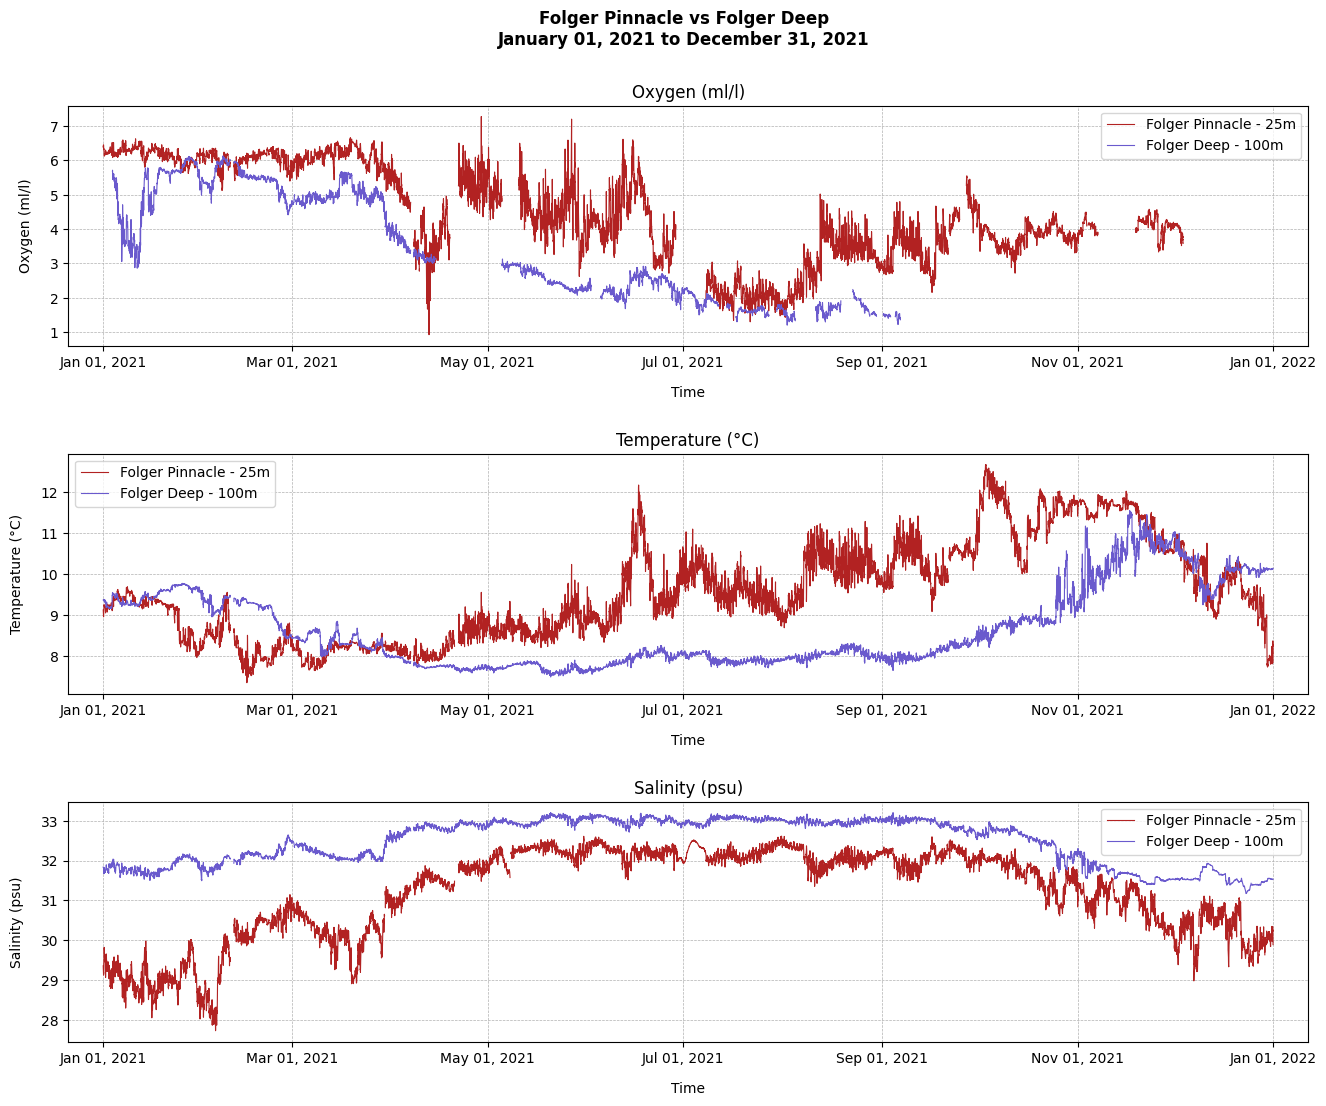

In [21]:
onc_plotting.compare_sensor_subplots(df1=deep_yr_21_indicators, df2=pin_yr_21_indicators, sensor_cols=["Oxygen (ml/l)", "Temperature (°C)", "Salinity (psu)"], location_code1=deep_locationCode, location_code2=pinnacle_locationCode)

Looking at the above plots, consider the following questions:

- Why are oxygen values generally higher at Folger Pinnacle than Folger Deep? What could cause them to be nearly the same (example late July - mid August)?

- Why were Folger Deep temperatures warmer than Folger Pinnacle temperatures during mid January - mid March?

- What could have caused them to be nearly the same in December?

- Why was salinity consistently higher at Folger Deep than Folger Pinnacle?

## 3. Plotting Shorter Time Series

Now say we'd like to inspect a specific time period within the year of 2021. Instead of repeating API calls, which are time and resource intensive, we can use the full-year DataFrames we have already generated, and extract smaller time periods of interest from them. 

### 3.1 Define Time Periods of Interest

From looking at the year long plots above we can identify several time periods that would prompt further investigation including a potential low oxygen event from July to September.

In the code below we define the start and end dates of the new time period as strings. 

To remain consistent with ONC's API, we use the ISO 8601 UTC format to define our dates: "YYYY-MM-DDTHH:MM:SS.sssZ".

In [22]:
# July - September
jul_01_str = "2021-07-01T00:00:00.000Z"
sep_01_str = "2021-09-01T00:00:00.000Z"

### 3.2 Convert Dates to 'Timestamp' Objects

After defining our dates as strings, we then convert them to pandas Timestamp objects using the pandas to_datetime function. This tells the program that each defined date is a moment in time, rather than just text, and is necessary for the next step.

In [23]:
# July - September
jul_01 = pandas.to_datetime(jul_01_str)
sep_01 = pandas.to_datetime(sep_01_str)

### 3.3 Create New DataFrames by 'Slicing' the Original

Now that the timestamps are defined, we use them to 'slice' specific time-based subsets of the full DataFrame. This is done using the pandas DataFrame.loc function, which selects only the rows from the DataFrame that fall between given start and stop dates.

#### 3.3.1 Slicing Example

Below, is an example of an initial DataFrame, with the red box outlining the start and end times where we slice it, according to the following code:

             deep_yr_21_indicators.loc["2021-01-01T04:00:00.000Z":"2021-01-01T08:00:00.000Z"]

<img src="(3) Folger Passage 2021 files/original_dataframe.png" width="" align="" />

We then see the new DataFrame this command produces.

<img src="(3) Folger Passage 2021 files/new_dataframe.png" width="" align="" />

#### 3.3.2 Apply Slicing

Following this same technique, we can isolate our period of interest at both Folger Deep and Folger Pinnacle. 

In [24]:
# Folger Deep: Slice views of the full-year data
deep_low_ox_df = deep_yr_21_indicators.loc[jul_01:sep_01]          # Potential low oxygen

In [25]:
# Folger Pinnacle: Slice views of the full-year data
pin_low_ox_df = pin_yr_21_indicators.loc[jul_01:sep_01]            # Potential low oxygen

### 3.4 Create Visualizations Using the DataFrames

And now that we have DataFrames with our specific period, we can plot them just like we would our original DataFrame. 

#### 3.4.1 Potential Low Oxygen Event at Folger Deep

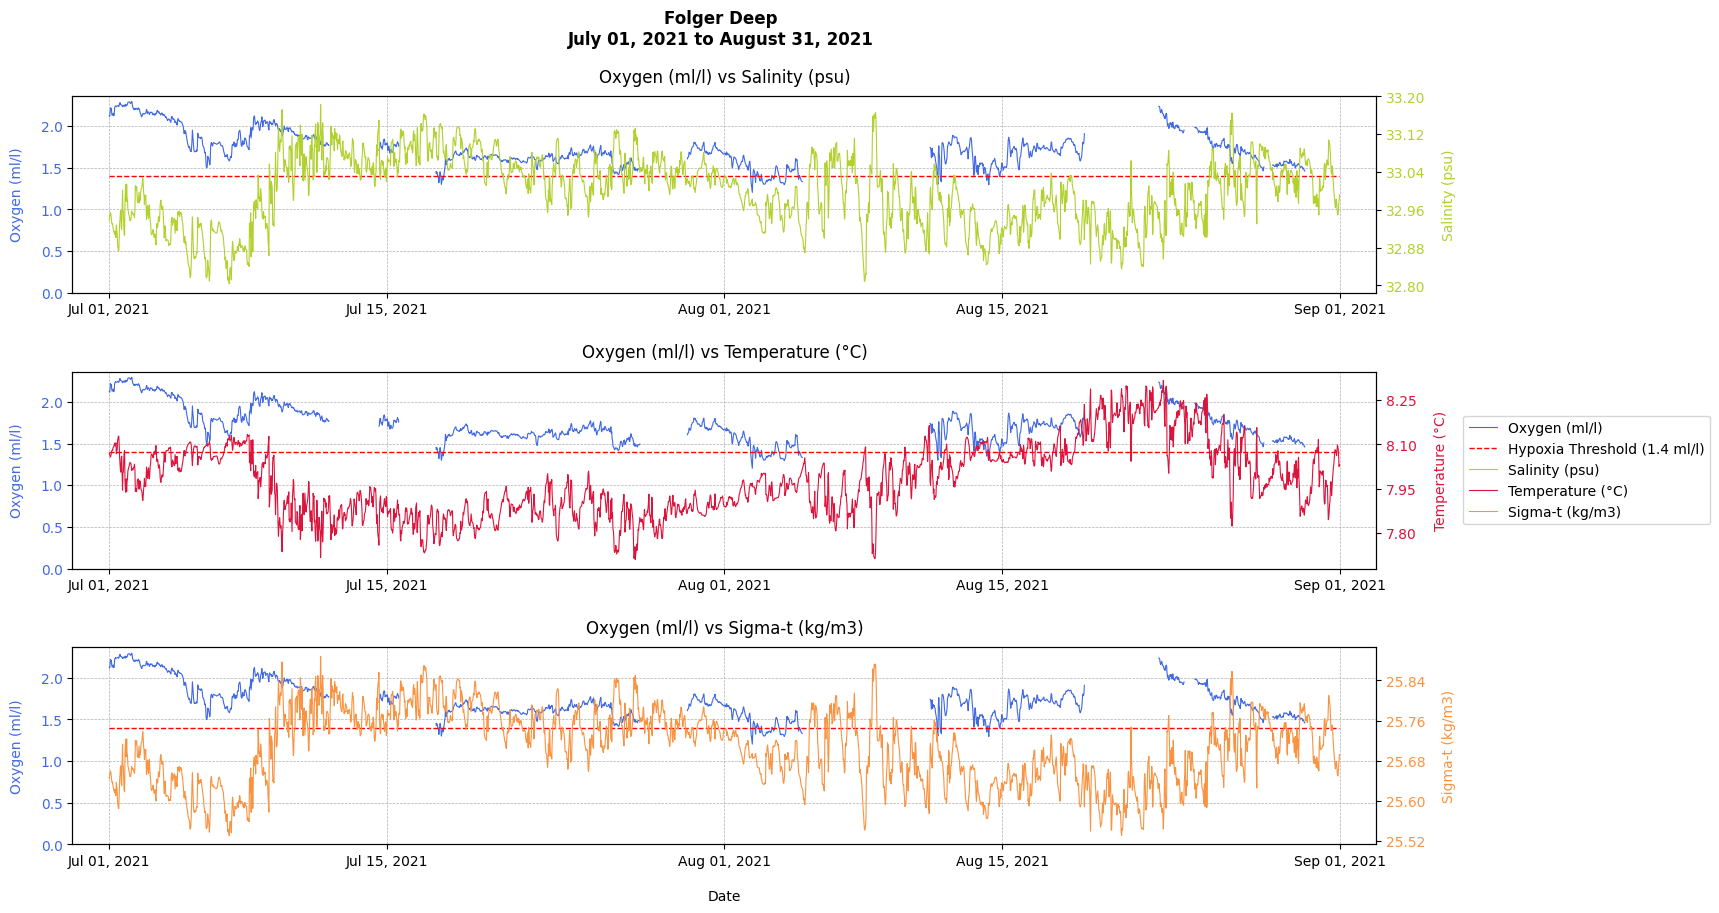

In [26]:
onc_plotting.subplot_all_with_oxygen(df=deep_low_ox_df, location_code=deep_locationCode)

#### 3.4.2 Potential Low Oxygen Event at Folger Deep

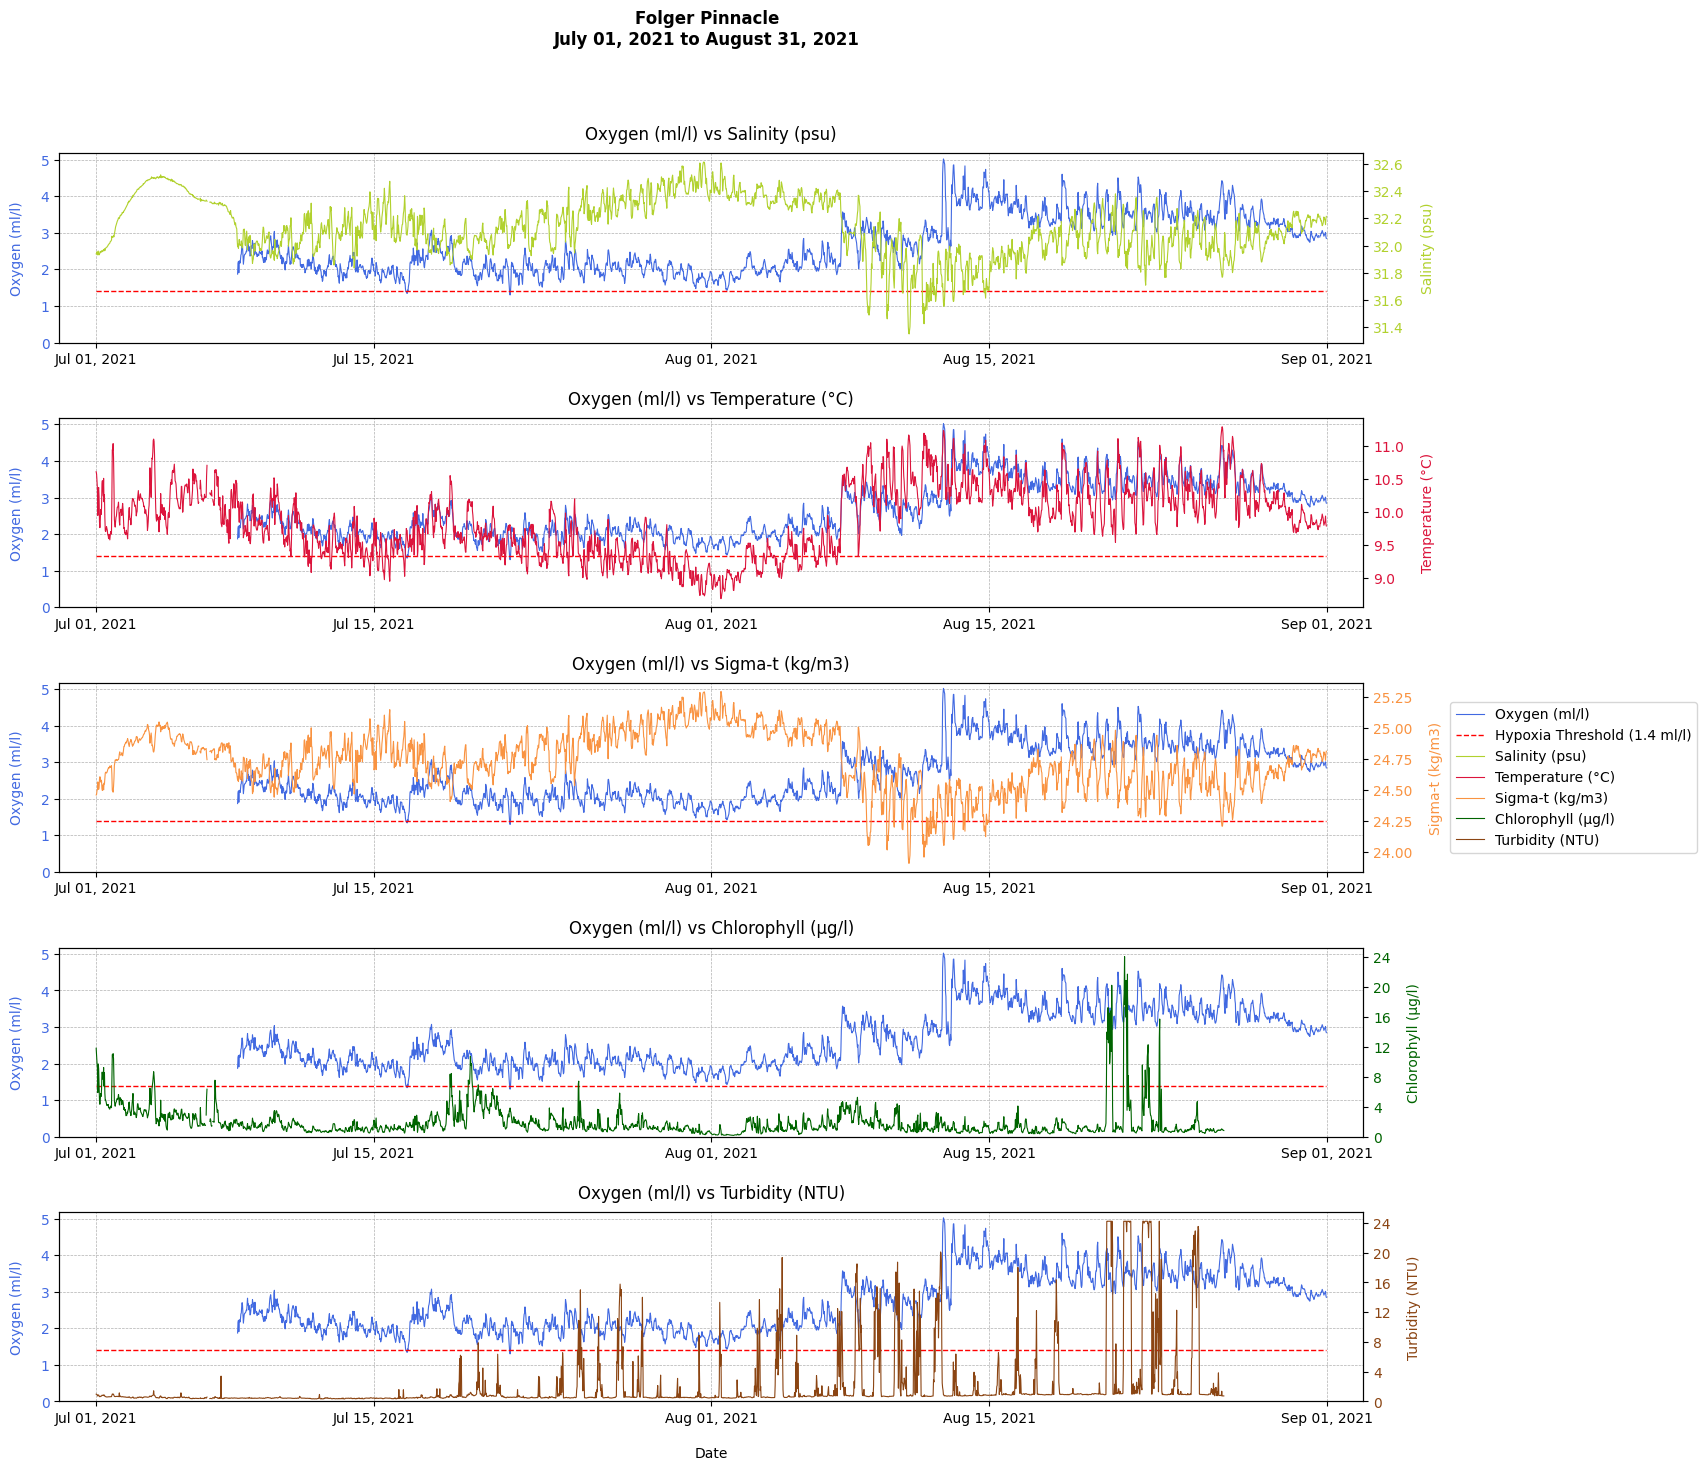

In [27]:
onc_plotting.subplot_all_with_oxygen(df=pin_low_ox_df, location_code=pinnacle_locationCode)

### 3.5 Interpret the Graphs

Looking at the above graphs, consider the following questions:

- How would you describe the relationship between salinity and oxygen? Why do we see a reversal in these properties over the course of the plot?

- Which parameter aligns most closely with oxygen? Why do you think they are closely aligned?

- Do you see any obvious correlations between oxygen and chlorophyll? 

- Oxygen and turbidity?

## 4. Potential High Chlorophyll Event

Looking at our year long plots we can also see another potential event of interest — high chlorophyll from mid September to November.

Following the same steps as in section 3 we can create a new DataFrame for this period.

### 4.1 Define Time Periods of Interest

In [28]:
# Mid September - November
sept_15_str = "2021-09-15T00:00:00.000Z"
nov_01_str = "2021-11-01T00:00:00.000Z"

### 4.2 Convert Dates to 'Timestamp' Objects

In [29]:
# Mid September - November
sept_15 = pandas.to_datetime(sept_15_str)
nov_01 = pandas.to_datetime(nov_01_str)

### 4.3 Create New DataFrames by 'Slicing' the Original

In [30]:
# Folger Pinnacle: Slice views of the full-year data
pin_high_chlor_df = pin_yr_21_indicators.loc[sept_15:nov_01]       # Potential high chlorophyll

### 4.4 Create Visualizations Using the DataFrame

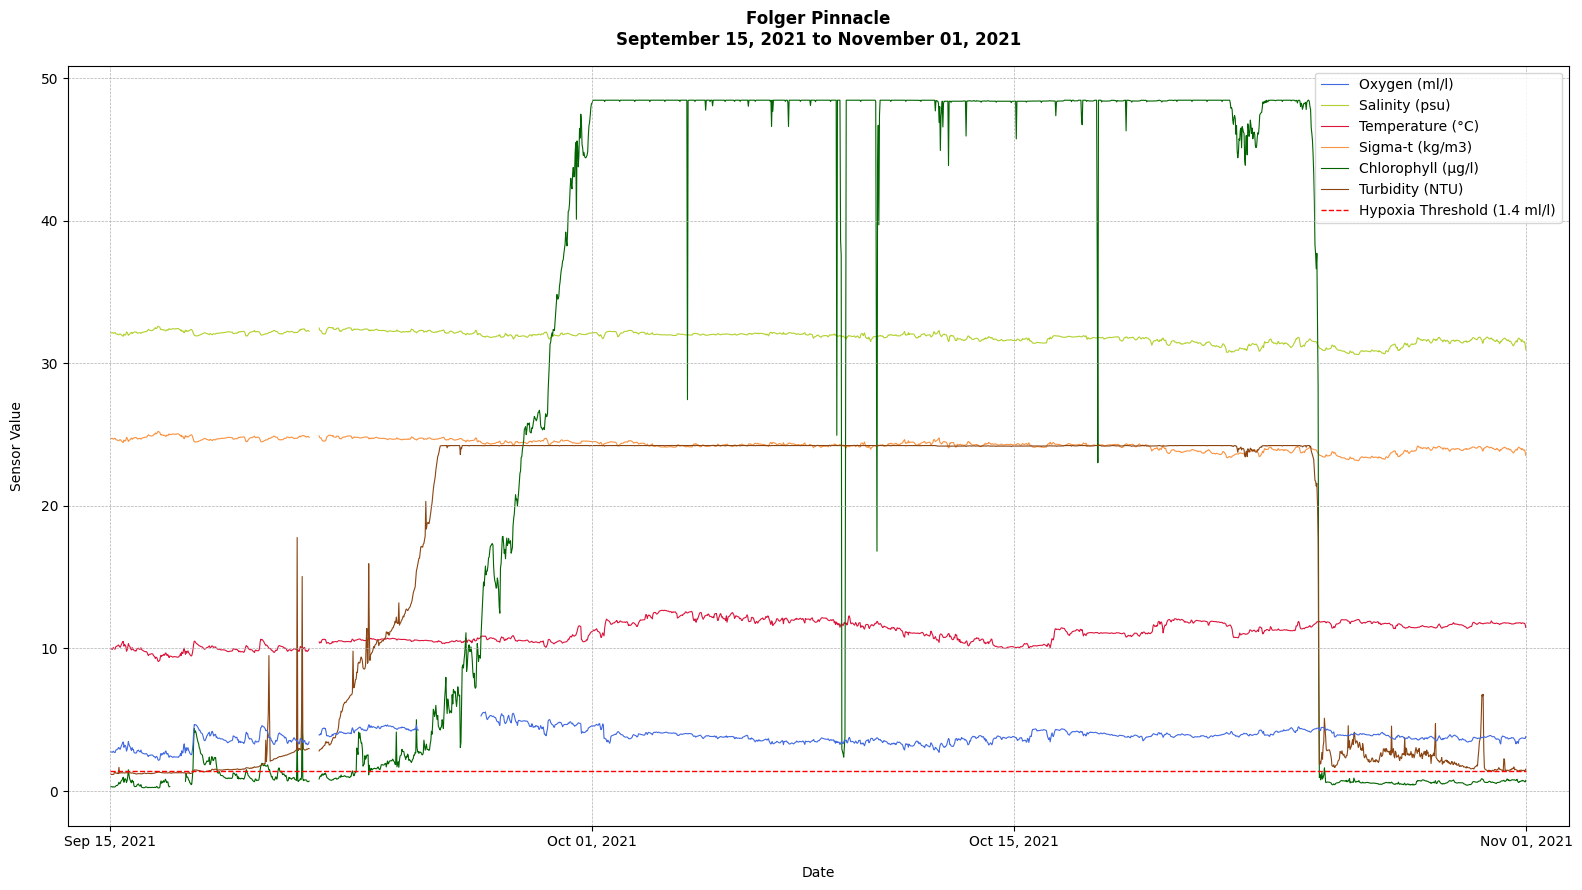

In [31]:
onc_plotting.plot_dataframe(df=pin_high_chlor_df, location_code=pinnacle_locationCode, start=sept_15, end=nov_01)

### 4.5 Interpret the Graph

Why did both the chlorophyll and turbidity curves go flat after reaching a high value? What could have caused the chlorophyll and turbidity to reach such high values at this time of year? Does it make sense for a phytoplankton bloom to happen in this area during late September and October?

The following photos show the Folger Pinnacle 3D camera array before deployment in 2010 (left) and after a year in the water (right). Does this photo give you any further ideas about what may have been happening with the chlorophyll and turbidity sensors? Consider and discuss as a class.

<img src="(3) Folger Passage 2021 files/folger_camera_array_2010_2011.png" width="" align="" />

Variations in CTD and oxygen records for Folger Deep (100m) have strong linkages with the regional upwelling and downwelling signals. The cold, salty upwelling season in 2021 started on 21 March, over a full month ahead of the climatological mean of April 26. This upwelling was sustained for over 6 months. Low oxygen conditions were observed as early as April in 2021. “Low dissolved oxygen levels have become the norm ion the Pacific Northwest coast, but this event started much earlier than we’ve seen in our records,” said Oregon State University Professor Francis Chan, director of the NOAA cooperative institute CIMERS. “This is the earliest start to the upwelling season in 35 years.” Typically, hypoxic conditions don’t appear until  late June or early July, he said. [Source article]

## 5. Oxygen Profile Offshore from Folger Passage

The following plot was created by combining a series of vertical casts (18 August 2021) from offshore (near 400 m deep) to inshore (100 m deep). You can see the locations of the casts as black dots on the map below. Looking at the section of dissolved oxygen (DO), notice the very low oxygen values indicated by purple shades with the red 1.4 ml/l contour.

<img src="(3) Folger Passage 2021 files/oxygen_profile_plots.jpeg" width="" align="" />

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ade8ed14-1fe0-4dd8-a068-473cbde195a5' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>